In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
train=pd.read_csv('Documents\CTR Project\\train.csv')
test = pd.read_csv("Documents\CTR Project\\test.csv")
ss = pd.read_csv("Documents\CTR Project\sample_submission_LJ2N3ZQ.csv")
train.shape , test.shape

((1888, 22), (762, 21))

In [4]:
train.head()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,...,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,...,0,0,0,0,0,0,0,0,10,0.700000
2,3,3,59,12801,16,5,1,Noon,2,11,...,1,0,1,0,0,0,0,0,16,0.002769
3,4,3,74,11037,30,4,0,Evening,15,9,...,0,0,0,0,0,0,0,0,10,0.010868
4,5,3,80,10011,27,5,1,Noon,6,26,...,0,0,1,0,0,0,0,0,14,0.142826


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campaign_id         1888 non-null   int64  
 1   sender              1888 non-null   int64  
 2   subject_len         1888 non-null   int64  
 3   body_len            1888 non-null   int64  
 4   mean_paragraph_len  1888 non-null   int64  
 5   day_of_week         1888 non-null   int64  
 6   is_weekend          1888 non-null   int64  
 7   times_of_day        1888 non-null   object 
 8   category            1888 non-null   int64  
 9   product             1888 non-null   int64  
 10  no_of_CTA           1888 non-null   int64  
 11  mean_CTA_len        1888 non-null   int64  
 12  is_image            1888 non-null   int64  
 13  is_personalised     1888 non-null   int64  
 14  is_quote            1888 non-null   int64  
 15  is_timer            1888 non-null   int64  
 16  is_emo

In [6]:
train.isnull().sum()

campaign_id           0
sender                0
subject_len           0
body_len              0
mean_paragraph_len    0
day_of_week           0
is_weekend            0
times_of_day          0
category              0
product               0
no_of_CTA             0
mean_CTA_len          0
is_image              0
is_personalised       0
is_quote              0
is_timer              0
is_emoticons          0
is_discount           0
is_price              0
is_urgency            0
target_audience       0
click_rate            0
dtype: int64

In [7]:
train.nunique()

campaign_id           1888
sender                  12
subject_len            170
body_len              1568
mean_paragraph_len     121
day_of_week              7
is_weekend               2
times_of_day             3
category                16
product                 43
no_of_CTA               40
mean_CTA_len            79
is_image                 6
is_personalised          2
is_quote                 7
is_timer                 1
is_emoticons             6
is_discount              2
is_price                 8
is_urgency               2
target_audience         17
click_rate            1810
dtype: int64

<AxesSubplot:ylabel='Density'>

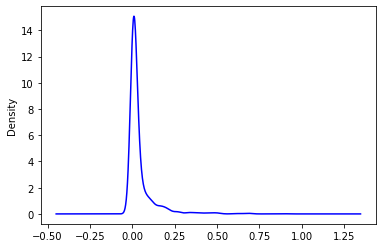

In [8]:
train.click_rate.plot.density(color='blue')

In [9]:
# Target variable is highly skewed, performing log transformation to reduce it
train['click_rate_log']  = np.log(train['click_rate']+1)

In [10]:
#before
print(train['click_rate'].skew())
#after
print(train['click_rate_log'].skew())

4.317743085163305
3.6811416192586184


In [11]:
# Creating the feature set or train and test and target set

y_train = train['click_rate']
y_train_log = train['click_rate_log']

x_train = train.iloc[:,1:21]
x_test = test.iloc[:,1:21]

In [12]:
x_train['data'] = 'train'
x_test['data'] = 'test'
all = pd.concat([x_train,x_test])
all.shape

(2650, 21)

In [13]:
# Creating a seperate column for Saturday and converting weekend to Sunday only
all['sat'] = np.where(all['day_of_week']== 5, 1, 0)
all['is_weekend'] = np.where(all['day_of_week']== 6, 1, 0)

In [14]:
# Converting time of day to numeric
# The time between morning and noon is less hence using - 3:3:2 gap ( Evening -3 , noon - 6 ,  morning - 8)
all['times_of_day']=all['times_of_day'].replace({'Noon':6, 'Morning':8, 'Evening':3})

# Change the datatype of character column
all['sender'] = all['sender'].astype(str)
all['category'] = all['category'].astype(str)
all['product'] = all['product'].astype(str)
all['target_audience'] = all['target_audience'].astype(str)
all['day_of_week'] = all['day_of_week'].astype(str)

In [15]:
# Feature Engineering 
# Deriving new column for Total Cta and total paragraph

all['total'] = all['no_of_CTA']*all['mean_CTA_len']
all['par'] = all['body_len']/all['mean_paragraph_len']

In [16]:
# Drop unique or almost unique column
all = all.drop(['is_price','is_timer'], axis=1)

In [17]:
x_train = all[all['data'] == 'train'] 
x_test = all[all['data'] == 'test']
                                                                                          
x_train = x_train.drop(['data'], axis=1)
x_test = x_test.drop(['data'], axis=1)

In [19]:
from flaml import AutoML
automl_log = AutoML()

In [20]:
automl_log.fit(x_train, y_train_log, task="regression",metric='r2',time_budget=5400,estimator_list = ['lgbm'],
          n_splits=10)

[flaml.automl: 08-14 15:50:11] {2444} INFO - task = regression
[flaml.automl: 08-14 15:50:11] {2446} INFO - Data split method: uniform
[flaml.automl: 08-14 15:50:11] {2449} INFO - Evaluation method: cv
[flaml.automl: 08-14 15:50:11] {2568} INFO - Minimizing error metric: 1-r2
[flaml.automl: 08-14 15:50:11] {2708} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 08-14 15:50:11] {3010} INFO - iteration 0, current learner lgbm
[flaml.automl: 08-14 15:50:11] {3143} INFO - Estimated sufficient time budget=3376s. Estimated necessary time budget=3s.
[flaml.automl: 08-14 15:50:11] {3190} INFO -  at 0.7s,	estimator lgbm's best error=0.8811,	best estimator lgbm's best error=0.8811
[flaml.automl: 08-14 15:50:11] {3010} INFO - iteration 1, current learner lgbm
[flaml.automl: 08-14 15:50:11] {3190} INFO -  at 1.0s,	estimator lgbm's best error=0.8811,	best estimator lgbm's best error=0.8811
[flaml.automl: 08-14 15:50:11] {3010} INFO - iteration 2, current learner lgbm
[flaml.automl:

[flaml.automl: 08-14 15:50:39] {3010} INFO - iteration 37, current learner lgbm
[flaml.automl: 08-14 15:50:40] {3190} INFO -  at 29.7s,	estimator lgbm's best error=0.4174,	best estimator lgbm's best error=0.4174
[flaml.automl: 08-14 15:50:40] {3010} INFO - iteration 38, current learner lgbm
[flaml.automl: 08-14 15:50:41] {3190} INFO -  at 30.6s,	estimator lgbm's best error=0.4174,	best estimator lgbm's best error=0.4174
[flaml.automl: 08-14 15:50:41] {3010} INFO - iteration 39, current learner lgbm
[flaml.automl: 08-14 15:50:47] {3190} INFO -  at 36.6s,	estimator lgbm's best error=0.4174,	best estimator lgbm's best error=0.4174
[flaml.automl: 08-14 15:50:47] {3010} INFO - iteration 40, current learner lgbm
[flaml.automl: 08-14 15:50:47] {3190} INFO -  at 37.1s,	estimator lgbm's best error=0.4174,	best estimator lgbm's best error=0.4174
[flaml.automl: 08-14 15:50:47] {3010} INFO - iteration 41, current learner lgbm
[flaml.automl: 08-14 15:50:48] {3190} INFO -  at 37.5s,	estimator lgbm's

[flaml.automl: 08-14 15:52:29] {3010} INFO - iteration 76, current learner lgbm
[flaml.automl: 08-14 15:52:30] {3190} INFO -  at 140.0s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:52:30] {3010} INFO - iteration 77, current learner lgbm
[flaml.automl: 08-14 15:52:32] {3190} INFO -  at 141.3s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:52:32] {3010} INFO - iteration 78, current learner lgbm
[flaml.automl: 08-14 15:52:44] {3190} INFO -  at 154.2s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:52:44] {3010} INFO - iteration 79, current learner lgbm
[flaml.automl: 08-14 15:52:53] {3190} INFO -  at 162.7s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:52:53] {3010} INFO - iteration 80, current learner lgbm
[flaml.automl: 08-14 15:52:55] {3190} INFO -  at 164.4s,	estimator l

[flaml.automl: 08-14 15:55:47] {3010} INFO - iteration 115, current learner lgbm
[flaml.automl: 08-14 15:55:48] {3190} INFO -  at 338.1s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:55:48] {3010} INFO - iteration 116, current learner lgbm
[flaml.automl: 08-14 15:55:58] {3190} INFO -  at 348.0s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:55:58] {3010} INFO - iteration 117, current learner lgbm
[flaml.automl: 08-14 15:56:18] {3190} INFO -  at 367.4s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:56:18] {3010} INFO - iteration 118, current learner lgbm
[flaml.automl: 08-14 15:56:19] {3190} INFO -  at 368.4s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:56:19] {3010} INFO - iteration 119, current learner lgbm
[flaml.automl: 08-14 15:56:21] {3190} INFO -  at 371.2s,	estima

[flaml.automl: 08-14 15:59:45] {3190} INFO -  at 574.4s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 15:59:45] {3010} INFO - iteration 154, current learner lgbm
[flaml.automl: 08-14 16:00:00] {3190} INFO -  at 589.9s,	estimator lgbm's best error=0.3993,	best estimator lgbm's best error=0.3993
[flaml.automl: 08-14 16:00:00] {3010} INFO - iteration 155, current learner lgbm
[flaml.automl: 08-14 16:00:13] {3190} INFO -  at 602.9s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:00:13] {3010} INFO - iteration 156, current learner lgbm
[flaml.automl: 08-14 16:00:18] {3190} INFO -  at 607.4s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:00:18] {3010} INFO - iteration 157, current learner lgbm
[flaml.automl: 08-14 16:00:21] {3190} INFO -  at 611.2s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.auto

[flaml.automl: 08-14 16:10:57] {3010} INFO - iteration 192, current learner lgbm
[flaml.automl: 08-14 16:11:02] {3190} INFO -  at 1252.1s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:11:02] {3010} INFO - iteration 193, current learner lgbm
[flaml.automl: 08-14 16:11:14] {3190} INFO -  at 1263.8s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:11:14] {3010} INFO - iteration 194, current learner lgbm
[flaml.automl: 08-14 16:11:27] {3190} INFO -  at 1276.3s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:11:27] {3010} INFO - iteration 195, current learner lgbm
[flaml.automl: 08-14 16:11:36] {3190} INFO -  at 1285.3s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:11:36] {3010} INFO - iteration 196, current learner lgbm
[flaml.automl: 08-14 16:11:50] {3190} INFO -  at 1299.5s,	e

[flaml.automl: 08-14 16:20:16] {3190} INFO -  at 1805.9s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:20:16] {3010} INFO - iteration 231, current learner lgbm
[flaml.automl: 08-14 16:20:24] {3190} INFO -  at 1814.2s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:20:24] {3010} INFO - iteration 232, current learner lgbm
[flaml.automl: 08-14 16:20:43] {3190} INFO -  at 1832.4s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:20:43] {3010} INFO - iteration 233, current learner lgbm
[flaml.automl: 08-14 16:21:00] {3190} INFO -  at 1849.6s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:21:00] {3010} INFO - iteration 234, current learner lgbm
[flaml.automl: 08-14 16:21:08] {3190} INFO -  at 1857.3s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml

[flaml.automl: 08-14 16:30:43] {3010} INFO - iteration 269, current learner lgbm
[flaml.automl: 08-14 16:31:51] {3190} INFO -  at 2500.4s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:31:51] {3010} INFO - iteration 270, current learner lgbm
[flaml.automl: 08-14 16:31:58] {3190} INFO -  at 2507.7s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:31:58] {3010} INFO - iteration 271, current learner lgbm
[flaml.automl: 08-14 16:32:03] {3190} INFO -  at 2512.3s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:32:03] {3010} INFO - iteration 272, current learner lgbm
[flaml.automl: 08-14 16:33:22] {3190} INFO -  at 2591.7s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:33:22] {3010} INFO - iteration 273, current learner lgbm
[flaml.automl: 08-14 16:33:47] {3190} INFO -  at 2616.4s,	e

[flaml.automl: 08-14 16:43:09] {3190} INFO -  at 3179.2s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:43:09] {3010} INFO - iteration 308, current learner lgbm
[flaml.automl: 08-14 16:43:31] {3190} INFO -  at 3200.7s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:43:31] {3010} INFO - iteration 309, current learner lgbm
[flaml.automl: 08-14 16:43:56] {3190} INFO -  at 3225.3s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:43:56] {3010} INFO - iteration 310, current learner lgbm
[flaml.automl: 08-14 16:44:02] {3190} INFO -  at 3231.8s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:44:02] {3010} INFO - iteration 311, current learner lgbm
[flaml.automl: 08-14 16:44:24] {3190} INFO -  at 3253.5s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml

[flaml.automl: 08-14 16:55:38] {3010} INFO - iteration 346, current learner lgbm
[flaml.automl: 08-14 16:55:44] {3190} INFO -  at 3933.8s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:55:44] {3010} INFO - iteration 347, current learner lgbm
[flaml.automl: 08-14 16:55:47] {3190} INFO -  at 3937.2s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:55:47] {3010} INFO - iteration 348, current learner lgbm
[flaml.automl: 08-14 16:56:57] {3190} INFO -  at 4006.9s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:56:57] {3010} INFO - iteration 349, current learner lgbm
[flaml.automl: 08-14 16:57:05] {3190} INFO -  at 4014.3s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 16:57:05] {3010} INFO - iteration 350, current learner lgbm
[flaml.automl: 08-14 16:57:33] {3190} INFO -  at 4042.5s,	e

[flaml.automl: 08-14 17:08:35] {3190} INFO -  at 4705.0s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:08:35] {3010} INFO - iteration 385, current learner lgbm
[flaml.automl: 08-14 17:08:51] {3190} INFO -  at 4721.2s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:08:51] {3010} INFO - iteration 386, current learner lgbm
[flaml.automl: 08-14 17:09:06] {3190} INFO -  at 4735.6s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:09:06] {3010} INFO - iteration 387, current learner lgbm
[flaml.automl: 08-14 17:09:21] {3190} INFO -  at 4750.8s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:09:21] {3010} INFO - iteration 388, current learner lgbm
[flaml.automl: 08-14 17:09:29] {3190} INFO -  at 4758.5s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml

[flaml.automl: 08-14 17:18:34] {3010} INFO - iteration 423, current learner lgbm
[flaml.automl: 08-14 17:18:55] {3190} INFO -  at 5324.7s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:18:55] {3010} INFO - iteration 424, current learner lgbm
[flaml.automl: 08-14 17:19:05] {3190} INFO -  at 5334.5s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:19:05] {3010} INFO - iteration 425, current learner lgbm
[flaml.automl: 08-14 17:19:21] {3190} INFO -  at 5350.5s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:19:21] {3010} INFO - iteration 426, current learner lgbm
[flaml.automl: 08-14 17:19:32] {3190} INFO -  at 5361.3s,	estimator lgbm's best error=0.3951,	best estimator lgbm's best error=0.3951
[flaml.automl: 08-14 17:19:32] {3010} INFO - iteration 427, current learner lgbm
[flaml.automl: 08-14 17:19:40] {3190} INFO -  at 5370.0s,	e

In [21]:
#r2 score
print(1-automl_log.best_loss)

0.6049133279680484


In [22]:
# Convert the prediction in original format
test_pred_log = np.exp(automl_log.predict(x_test))-1

In [23]:
test_pred_log

array([ 7.46816385e-02,  6.55969444e-01,  1.60830542e-01,  1.72897782e-01,
        1.51957874e-01,  2.36422181e-02,  4.94178760e-03,  1.20935924e-02,
        5.46911957e-03,  2.03016443e-02,  2.08601782e-02,  1.60079496e-02,
        1.29971763e-02,  9.30859205e-03,  6.00005859e-03,  9.84241662e-03,
        4.25422512e-03,  2.35826162e-02,  1.27745106e-02,  3.17319692e-02,
        3.00373426e-02,  1.43518924e-02,  9.12007460e-03,  9.09098535e-03,
        1.99889763e-03,  7.85544887e-03,  6.30286613e-02,  1.00991058e-02,
        8.72569674e-02,  1.27518912e-02,  3.30853549e-03,  5.10398232e-02,
        3.88042764e-03,  1.03528149e-01,  1.67182917e-02,  1.73809474e-02,
        1.74746549e-03,  3.16957306e-03,  7.30138229e-03,  9.65985981e-03,
        1.04805170e-02,  9.73108118e-03,  5.48440388e-03,  5.50312134e-02,
        5.42417041e-02,  7.03401808e-03,  1.69592345e-02,  1.64195433e-02,
        1.65323947e-02,  1.11471616e-02,  7.22464415e-03,  2.03132988e-02,
        1.14330492e-02,  